In [1]:
import pandas as pd

df = pd.read_csv("../healthcare_dataset.csv")

df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])

daily_admissions = df.groupby("Date of Admission").size()

daily_admissions = daily_admissions.rename("admissions")
daily_admissions = daily_admissions.sort_index()
daily_admissions = daily_admissions.asfreq("D", fill_value=0)

print(daily_admissions.head())
print(daily_admissions.tail())
print(daily_admissions.index.freq)

Date of Admission
2019-05-08    27
2019-05-09    38
2019-05-10    17
2019-05-11    25
2019-05-12    36
Freq: D, Name: admissions, dtype: int64
Date of Admission
2024-05-03    31
2024-05-04    24
2024-05-05    26
2024-05-06    33
2024-05-07    33
Freq: D, Name: admissions, dtype: int64
<Day>


In [2]:
import numpy as np

def make_lag_features(series, n_lags=7):
    df_ml = pd.DataFrame({"admissions": series})
    
    #For Lag 1,2,...n
    for lag in range(1, n_lags + 1):
        df_ml[f"lag_{lag}"] = series.shift(lag)
    
    # Calendar features
    df_ml["day_of_week"] = df_ml.index.dayofweek  # 0=Mon ... 6=Sun
    df_ml["month"] = df_ml.index.month
    
    # Droprows that became NaN becuase of shifting
    df_ml = df_ml.dropna()
    return df_ml

ml_df = make_lag_features(daily_admissions, n_lags=7)

print(ml_df.head())
print(ml_df.tail())

                   admissions  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
Date of Admission                                                         
2019-05-15                 39   33.0   23.0   36.0   25.0   17.0   38.0   
2019-05-16                 27   39.0   33.0   23.0   36.0   25.0   17.0   
2019-05-17                 35   27.0   39.0   33.0   23.0   36.0   25.0   
2019-05-18                 18   35.0   27.0   39.0   33.0   23.0   36.0   
2019-05-19                 33   18.0   35.0   27.0   39.0   33.0   23.0   

                   lag_7  day_of_week  month  
Date of Admission                             
2019-05-15          27.0            2      5  
2019-05-16          38.0            3      5  
2019-05-17          17.0            4      5  
2019-05-18          25.0            5      5  
2019-05-19          36.0            6      5  
                   admissions  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
Date of Admission                                                     

In [3]:
X = ml_df.drop(columns=["admissions"])
y = ml_df["admissions"]

print(X.shape)
print(y.shape)

(1820, 9)
(1820,)


In [4]:
data_ml = ml_df.dropna().sort_index()

train_size = int(len(data_ml) * 0.7)
train_ml = data_ml.iloc[:train_size]
test_ml  = data_ml.iloc[train_size:]

# Features (X) and Target (y)
feature_cols = ['lag_1', 'lag_7', 'day_of_week', 'month']

X_train = train_ml[feature_cols]
y_train = train_ml['admissions']

X_test  = test_ml[feature_cols]
y_test  = test_ml['admissions']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train period:", X_train.index.min(), "to", X_train.index.max())
print("Test period :", X_test.index.min(), "to", X_test.index.max())

Train shape: (1274, 4) Test shape: (546, 4)
Train period: 2019-05-15 00:00:00 to 2022-11-08 00:00:00
Test period : 2022-11-09 00:00:00 to 2024-05-07 00:00:00


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return rmse, mae, mape, accuracy

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Model 1
gb_model_1 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=42
)

gb_model_1.fit(X_train, y_train)
y_pred_gb_1 = gb_model_1.predict(X_test)

rmse1, mae1, mape1, acc1 = evaluate_model(y_test, y_pred_gb_1)

print("Gradient Boosting model-1 trained.")

Gradient Boosting model-1 trained.


In [7]:
# Gradient Boosting Model 2 (Increasing estimators)
gb_model_2 = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=3,
    random_state=42
)

gb_model_2.fit(X_train, y_train)
y_pred_gb_2 = gb_model_2.predict(X_test)

rmse2, mae2, mape2, acc2 = evaluate_model(y_test, y_pred_gb_2)

print("Gradient Boosting model-2 trained.")

Gradient Boosting model-2 trained.


In [8]:
# Gradient Boosting Model 3 (Increase max_depth)
gb_model_3 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

gb_model_3.fit(X_train, y_train)
y_pred_gb_3 = gb_model_3.predict(X_test)

rmse3, mae3, mape3, acc3 = evaluate_model(y_test, y_pred_gb_3)

print("Gradient Boosting model-3 trained.")

Gradient Boosting model-3 trained.


In [9]:
# Gradient Boosting Model 4 (Change learning rate)

gb_model_4 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)

gb_model_4.fit(X_train, y_train)
y_pred_gb_4 = gb_model_4.predict(X_test)

rmse4, mae4, mape4, acc4 = evaluate_model(y_test, y_pred_gb_4)

print("Gradient Boosting model-4 trained.")

Gradient Boosting model-4 trained.


In [10]:
# Gradient Boosting Model 5 (Varying all parameters)
gb_model_5 = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.01,
    random_state=42
)

gb_model_5.fit(X_train, y_train)
y_pred_gb_5 = gb_model_5.predict(X_test)

rmse5, mae5, mape5, acc5 = evaluate_model(y_test, y_pred_gb_5)

print("Gradient Boosting model-5 trained.")

Gradient Boosting model-5 trained.


In [11]:
gb_results = pd.DataFrame({
    "Model": ["GB-1", "GB-2", "GB-3", "GB-4", "GB-5"],
    "RMSE": [rmse1, rmse2, rmse3, rmse4, rmse5],
    "MAE": [mae1, mae2, mae3, mae4, mae5],
    "MAPE": [mape1, mape2, mape3, mape4, mape5],
    "Accuracy": [acc1, acc2, acc3, acc4, acc5]
})

gb_results

,Model,RMSE,MAE,MAPE,Accuracy
0,GB-1,6.123725,4.939744,17.602212,82.397788
1,GB-2,6.284123,5.060104,18.032112,81.967888
2,GB-3,6.504092,5.221432,18.608902,81.391098
3,GB-4,6.043379,4.885508,17.405494,82.594506
4,GB-5,6.149816,4.986230,17.764944,82.235056


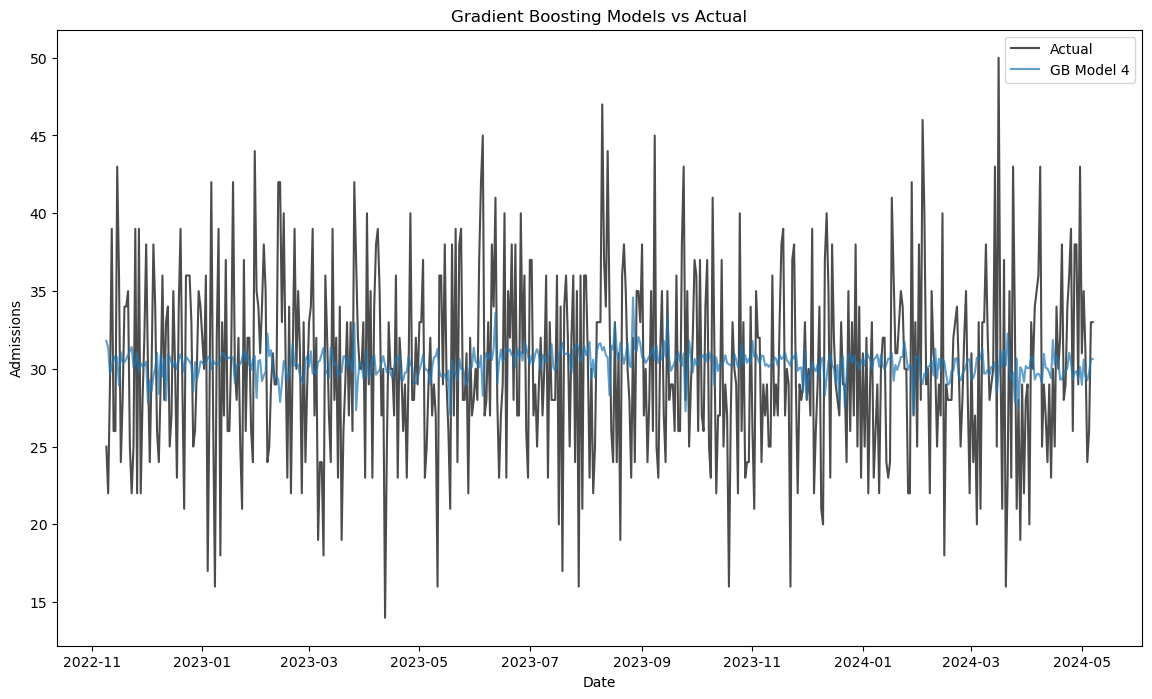

In [12]:
# Plotting

import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
plt.plot(y_test.index, y_test, label="Actual", color="black", alpha=0.7)

# Plot each model prediction
#plt.plot(y_test.index, y_pred_gb_1, label="GB Model 1", alpha=0.7)
#plt.plot(y_test.index, y_pred_gb_2, label="GB Model 2", alpha=0.7)
#plt.plot(y_test.index, y_pred_gb_3, label="GB Model 3", alpha=0.7)
plt.plot(y_test.index, y_pred_gb_4, label="GB Model 4", alpha=0.7)
#plt.plot(y_test.index, y_pred_gb_5, label="GB Model 5", alpha=0.7)

plt.title("Gradient Boosting Models vs Actual")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.show()

In [13]:
gb_pred_df = pd.DataFrame({
    "date": y_test.index,
    "gb_1": y_pred_gb_1,
    "gb_2": y_pred_gb_2,
    "gb_3": y_pred_gb_3,
    "gb_4": y_pred_gb_4,
    "gb_5": y_pred_gb_5
})

gb_pred_df.to_csv("../70_30 split/predictions/gb_predictions.csv", index=False)

print("Gradient Boosting predictions saved to gb_predictions.csv")

Gradient Boosting predictions saved to gb_predictions.csv
